In [1]:

import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.impute import SimpleImputer

In [2]:

ip_data = pd.read_csv("redwine.csv", delimiter=';')


imputer = SimpleImputer(strategy='median')
ip_data = pd.DataFrame(imputer.fit_transform(ip_data), columns=ip_data.columns)

X = ip_data

In [3]:
def clustering_pipeline(X, n_clusters, technique='kmeans', preprocessing=None):
    # Preprocessing
    if preprocessing == 'normalize':
        X = StandardScaler().fit_transform(X)
    elif preprocessing == 'transform':
        X = MinMaxScaler().fit_transform(X)
    elif preprocessing == 'pca':
        X = PCA(n_components=2).fit_transform(X)
    elif preprocessing == 't+n':
        X = StandardScaler().fit_transform(X)
        X = PCA(n_components=2).fit_transform(X)
    

    if technique == 'kmeans':
        m = KMeans(n_clusters=n_clusters, random_state=42)
    elif technique == 'hierarchical':
        m = AgglomerativeClustering(n_clusters=n_clusters)
    elif technique == 'meanshift':
        m = MeanShift()
    
    labels = m.fit_predict(X)

    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else 'NA'
    calinski = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else 'NA'
    davies = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else 'NA'
    
    return silhouette, calinski, davies

In [4]:

ccluster = [3, 4, 5]
prepro = [None, 'normalize', 'transform', 'pca', 't+n']
tec = ['kmeans', 'hierarchical', 'meanshift']
op = []


for technique in tec:
    for n_clusters in ccluster:
        for method in prepro:
            silhouette, calinski, davies = clustering_pipeline(X, n_clusters, technique, method)
            op.append({
                'Technique': technique,
                'Preprocessing': method,
                'Clusters': n_clusters,
                'Silhouette': round(silhouette,4),
                'Calinski-Harabasz': round(calinski,4),
                'Davies-Bouldin': round(davies,4)
            })




op_df = pd.DataFrame(op)

In [5]:
tec = op_df['Technique'].unique()

st = []
for technique in tec:
    sdf = op_df[op_df['Technique'] == technique]
    pvdf = sdf.pivot(index='Clusters', columns='Preprocessing', values=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'])
    
    styled_table = pvdf.style.set_caption(f"Performance of {technique.capitalize()} Clustering") \
                   .set_table_styles({
                       'Silhouette': [{'selector': 'td', 'props': [('background-color', 'white')]}],
                       'Calinski-Harabasz': [{'selector': 'td', 'props': [('background-color', 'white')]}],
                       'Davies-Bouldin': [{'selector': 'td', 'props': [('background-color', 'white')]}]
                   })
    
    st.append(styled_table)

for table in st:
    display(table)


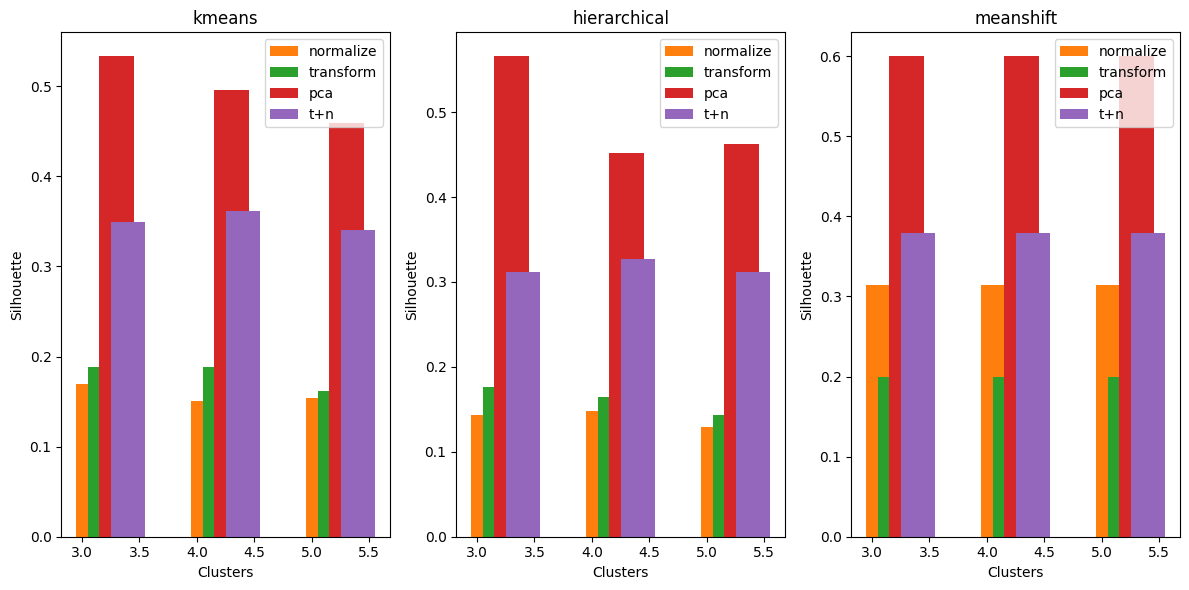

In [7]:
import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(1, len(op_df['Technique'].unique()), figsize=(12, 6))

for ax, technique in zip(axes, op_df['Technique'].unique()):
    data = op_df[op_df['Technique'] == technique]
    for preprocessing in data['Preprocessing'].unique():
        subset = data[data['Preprocessing'] == preprocessing]
        ax.bar(subset['Clusters'] + 0.1 * np.where(data['Preprocessing'].unique() == preprocessing)[0][0],
               subset['Silhouette'], width=0.3, label=preprocessing)
    ax.set_title(technique)
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Silhouette')
    ax.legend()

plt.tight_layout()
plt.show()

